In [5]:
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 70.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [3]:
import matplotlib.pyplot as plt

In [6]:
from qutip import *

In [7]:
import random

In [8]:
from math import comb

In [9]:
def gen_fock(no, N_basis=32, low=1, high=16):
    focks = np.zeros((no, N_basis, N_basis), dtype=np.complex128)
    for i in range(no):
        focks[i] = fock_dm(N_basis,random.randint(low, high))[:,:]
    return focks

In [10]:
def gen_coh(no, N_basis=32, low=1e-6, high=3):
    cohs = np.zeros((no, N_basis, N_basis), dtype=np.complex128)
    for i in range(no):
        cohs[i] = coherent_dm(N_basis, random.uniform(low, high))[:,:]
    return cohs

In [11]:
def gen_therm(no, N_basis=32, low=0, high=16):
    therms = np.zeros((no, N_basis, N_basis), dtype=np.complex128)
    for i in range(no):
        therms[i] = thermal_dm(N_basis, random.randint(low, high))[:,:]
    return therms

In [12]:
def gen_bin_dm(mu, dim=32):

    S = random.randint(1, 10)
    N = random.randint(2, int(np.round(dim/(S+1) - 1)))

    bin_state = Qobj(np.zeros(dim), dims=[[dim], [1]])

    normalization_factor = 1 / np.sqrt(2 ** (N + 1))

    for m in range(N + 1):
        sign = (-1) ** (mu * m)
        fock_index = (S + 1) * m
        if fock_index < dim:
            bin_fac = np.sqrt(comb(N+1, m))
            bin_state += sign * bin_fac * basis(dim, fock_index)

    bin_state = bin_state.unit()
    bin_dm = bin_state*bin_state.dag()
    return bin_dm

In [13]:
def gen_fock_Q(no, betas, N_basis=32, low=1, high=16):
    fock_Qs = np.zeros((no, N_basis, N_basis))
    for i in range(no):
        rho_fock = fock_dm(N_basis,random.randint(low, high))
        fock_Qs[i] = qfunc(rho_fock, betas, betas)
    return fock_Qs

In [14]:
def gen_coh_Q(no, betas, N_basis=32, low=1e-6, high=3):
    coh_Qs = np.zeros((no, N_basis, N_basis))
    for i in range(no):
        rho_coh = coherent_dm(N_basis, random.uniform(low, high))
        coh_Qs[i] = qfunc(rho_coh, betas, betas)
    return coh_Qs

In [15]:
def gen_therm_Q(no, betas, N_basis=32, low=0, high=16):
    therm_Qs = np.zeros((no, N_basis, N_basis))
    for i in range(no):
        rho_therm = thermal_dm(N_basis, random.randint(low, high))
        therm_Qs[i] = qfunc(rho_therm, betas, betas)
    return therm_Qs

In [16]:
def gen_bin_Q(no, betas, N_basis=32, mu=1):
    bin_Qs = np.zeros((no, N_basis, N_basis))
    for i in range(no):
        bin_dm = gen_bin_dm(mu=mu, dim=N_basis)
        bin_Qs[i] = qfunc(bin_dm, betas, betas)
    return bin_Qs

In [18]:
datano = 1000
N_basis = 32
betas = np.linspace(-5,5,32)

In [19]:
fock_Qs = gen_fock_Q(datano, betas)
coherent_Qs = gen_coh_Q(datano, betas)
thermal_Qs = gen_therm_Q(datano, betas)
bin_Qs = gen_bin_Q(datano, betas)

In [24]:
fock_labels = np.zeros(datano)
coherent_labels = np.ones(datano)
thermal_labels = np.full(datano, 2)
bin_labels = np.full(datano, 3)

In [25]:
all_states = np.concatenate([fock_Qs, coherent_Qs, thermal_Qs, bin_Qs], axis=0)
all_labels = np.concatenate([fock_labels, coherent_labels, thermal_labels, bin_labels], axis=0)
all_states = np.expand_dims(all_states, axis=-1)
all_states = all_states / np.max(all_states)

In [31]:
all_states.shape[0]/datano

4.0

In [28]:
indices = np.arange(all_states.shape[0])
np.random.shuffle(indices)
all_states, all_labels = all_states[indices], all_labels[indices]

X_train, X_val, y_train, y_val = train_test_split(all_states, all_labels, test_size=0.2)

In [32]:
y_train_one_hot = to_categorical(y_train, num_classes=4)
y_val_one_hot = to_categorical(y_val, num_classes=4)

In [33]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (4, 4), activation='relu', input_shape=(len(betas), len(betas), 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
history = model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_val, y_val_one_hot))

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7129 - loss: 0.7752 - val_accuracy: 0.9825 - val_loss: 0.0651
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9856 - loss: 0.0609 - val_accuracy: 0.9762 - val_loss: 0.1273
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9850 - loss: 0.0827 - val_accuracy: 0.9825 - val_loss: 0.0737
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9900 - loss: 0.0358 - val_accuracy: 0.9613 - val_loss: 0.1045
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9927 - loss: 0.0255 - val_accuracy: 0.9925 - val_loss: 0.0166
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9929 - loss: 0.0199 - val_accuracy: 0.9937 - val_loss: 0.0145
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9955 - loss: 0.0117 - val_accuracy: 0.9937 - val_loss: 0.0109
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9927 - loss: 0.0133 - val_accuracy: 0

In [35]:
test_loss, test_acc = model.evaluate(X_val, y_val_one_hot)
print(f'Test Accuracy: {test_acc:.2f}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0281 
Test Accuracy: 0.98


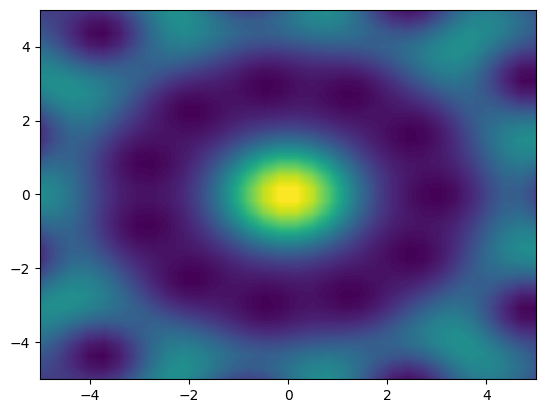

In [40]:
test = gen_bin_Q(1, betas)
test = np.expand_dims(test, axis=-1)
test.shape
test = test/np.max(test)
plt.contourf(betas,betas,test[0,:,:,0],100)

Label Order: 0: Fock, 1: Coherent, 2: Thermal, 3: Binomial

In [41]:
prediction = model.predict(test)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.01232335, 0.00802149, 0.01985204, 0.9598031 ]], dtype=float32)

In [42]:
predicted_class = np.argmax(prediction)
print(f"Predicted class: {predicted_class}")

Predicted class: 3
